# 1. Introducition
The following code contains the creation and training of an RNN Model using Keras and TensorFlow. The project was originally started in Kaggle but was moved to Jupyter Notebook so as to utilize hardware acceleration. The aim of the model is to decide whether tweets entered are one of eight emotions. The emotions are as followed: {'joy', 'surprise', 'sadness', 'anger', 'trust', 'fear', 'disgust', 'anticipation'}. Many of the porcesses taken and utilized were thanks to the GPU-Accelerated performance of the Jupyter Notebook. With that I was able to perform more epochs as well as create more versions as well.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 2 Importing Files
Due to the JSON being a Nested Json, the original df did not fully contain the information needed. Due to this another dataframe was created with json_normalize so as to have the tweet_id, and the text, which were very importan. The tweet_id was necessary so as to add combine the other dataframes that contained the training and test data. The reason for this was so as to have the dataframe be able to share the tweet text via the tweet_id. Afterwards, separate dataframes where created to have the Training and Testing Data Separate from each other, as well as the emotion labels.

In [2]:
#Creating Twitter DF From Json Files
twitterDM = "Twitter/tweets_DM.json"
twitter_df = pd.read_json(twitterDM, lines=True)
twitter_df.head()

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


In [3]:
#Getting the Tweet Inform From the Source Column of the Original DF
twitterDM_df = pd.json_normalize(twitter_df._source, record_prefix=None)
twitterDM_df.columns = twitterDM_df.columns.str.replace('^tweet.', '')
twitterDM_df

C:\Users\galve\AppData\Local\Temp\ipykernel_15224\3164084898.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  twitterDM_df.columns = twitterDM_df.columns.str.replace('^tweet.', '')


,hashtags,tweet_id,text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...,...
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,[],0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [4]:
#Creating Data_Identification DF
twitterID = "Twitter/data_identification.csv"
twitid_df = pd.read_csv(twitterID)
twitid_df

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [5]:
#Creating Emotion DF
emotion = "Twitter/emotion.csv"
twitemo_df = pd.read_csv(emotion)
twitemo_df

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [6]:
#Combining DataFrames
dfs = [twitterDM_df,twitid_df,twitemo_df]
twitcom_df = pd.concat([x.set_index('tweet_id') for x in dfs], axis=1).reset_index()
twitcom_df

,tweet_id,hashtags,text,identification,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",test,NaN
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,0x2de201,[],"""Trust is not the same as faith. A friend is s...",test,NaN
...,...,...,...,...,...
1867530,0x316b80,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...,test,NaN
1867531,0x29d0cb,[],I swear all this hard work gone pay off one da...,test,NaN
1867532,0x2a6a4f,[],@Parcel2Go no card left when I wasn't in so I ...,test,NaN
1867533,0x24faed,[],"Ah, corporate life, where you can date <LH> us...",train,joy


In [7]:
#Extracting the Training and testing Data
twitTrain_df = twitcom_df.loc[twitcom_df['identification'] == 'train']
twitTest_df = twitcom_df.loc[twitcom_df['identification'] == 'test']


### Indexes had to be reset for other uses after everything was separated.

In [8]:
#Reseting and Testing Train Dataframe
twitTrain_df.reset_index(drop=True, inplace=True)
twitTrain_df

,tweet_id,hashtags,text,identification,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,train,anticipation
...,...,...,...,...,...
1455558,0x321566,"[NoWonder, Happy]",I'm SO HAPPY!!! #NoWonder the name of this sho...,train,joy
1455559,0x38959e,[],In every circumtance I'd like to be thankful t...,train,joy
1455560,0x2cbca6,[blessyou],there's currently two girls walking around the...,train,joy
1455561,0x24faed,[],"Ah, corporate life, where you can date <LH> us...",train,joy


In [9]:
#Reseting and Testing Test Dataframe
twitTest_df.reset_index(drop=True, inplace=True)
twitTest_df

,tweet_id,hashtags,text,identification,emotion
0,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k...",test,NaN
1,0x2de201,[],"""Trust is not the same as faith. A friend is s...",test,NaN
2,0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...,test,NaN
3,0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #...",test,NaN
4,0x26289a,[],"In these tough times, who do YOU turn to as yo...",test,NaN
...,...,...,...,...,...
411967,0x2913b4,[],"""For this is the message that ye heard from th...",test,NaN
411968,0x2a980e,[],"""There is a lad here, which hath five barley l...",test,NaN
411969,0x316b80,"[mixedfeeling, butimTHATperson]",When you buy the last 2 tickets remaining for ...,test,NaN
411970,0x29d0cb,[],I swear all this hard work gone pay off one da...,test,NaN


In [10]:
#Extracting and Testing Training Data
tweets_train = twitTrain_df['text']
tweets_test = twitTest_df['text']
emolabel_train = twitTrain_df['emotion']
tweets_train[50], emolabel_train[50]

('@sydbell1 @strut4cancer £50 donates to Macmillan       👍😎👌 <LH> !!', 'joy')

# 3. Preprocessing
Originally, no preprocessing was done. This was becuase I thought that even without it I would still be able to get a 0.7 or above accuracy. An assumption that proved to be true. With that being said, for some reason or another, I decided to add preprocessing of the data to see how far I could take this. The preprocessing step was mostly to remove usernames, one letter words, unnecessary stopwords, spaces, the lower of text for uniformity and word lemmetimization. I also wanted to do more but I think I did enough. (I got tired). Also tested whether or not removing stop words performed better or worse. You can tell which one I chose based on int's inclusion/exclusion in th immediate following data. Plan to utilize emoji detection as well.

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import emoji 

def preprocess_text(Tweet):
        #Removes Username
        Tweet = re.sub('@[^\s]+','',Tweet)
        
        #Demojize Emojis
        Tweet = emoji.demojize(Tweet)
        Tweet = Tweet.replace(":"," ")
        Tweet = ' '.join(Tweet.split())
        
        #Removes LH
        Tweet = re.sub('<[^\s]+','',Tweet)
        
        #Removes Hashtage
        Tweet = re.sub('#','',Tweet)
        
        # Remove puntuations and numbers
        Tweet = re.sub('[^a-zA-Z]', ' ', Tweet)
               
        # Remove single characters
        Tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', Tweet)

        # remove multiple spaces
        Tweet = re.sub(r'\s+', ' ', Tweet)
        Tweet = Tweet.lower()
        
        # Convert Text sentence to Tokens
        Tweet = word_tokenize(Tweet)
       
        #Remove unncecessay stopwords #####Disabled#####
        stop_words = stopwords.words('english')
        filtered_text = []
        for t in Tweet:
            #if t not in stop_words:
            filtered_text.append(t)

        # Word lemmatization
        wordnet_lemmatizer = WordNetLemmatizer()
        processed_text1 = []
        for t in filtered_text:
            word1 = wordnet_lemmatizer.lemmatize(t, pos="n")
            word2 = wordnet_lemmatizer.lemmatize(word1, pos="v")
            word3 = wordnet_lemmatizer.lemmatize(word2, pos=("a"))
            processed_text1.append(word3)

        result = ""
        for word in processed_text1:
            result = result + word + " "
        result = result.rstrip() 
        
        return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\galve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\galve\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
tweets_train_pre = []
for c in twitTrain_df['text'].values:
    tweets_train_pre.append(preprocess_text(c))

In [13]:
tweets_test_pre = []
for c in twitTest_df['text'].values:
    tweets_test_pre.append(preprocess_text(c))

In [14]:
print(tweets_train[50])
print(tweets_train_pre[50])
print(emolabel_train[50])

@sydbell1 @strut4cancer £50 donates to Macmillan       👍😎👌 <LH> !!
donate to macmillan thumb up smile face with sunglass ok hand
joy


In [15]:
print(tweets_test[50])
print(tweets_test_pre[50])

When your husband forgots  to turn his alarm clock off and its a bank holiday. That. <LH>
when your husband forgots to turn his alarm clock off and it bank holiday that


# 4 Tokenization
As mentioned before, certain decision were decided due to the speed of how things could be. Here is where that started, with usage of Tensorflow, Keras, and trying to make code that make things faster but instead made things longer. I decided to go with the Keras Tokenization as I was able to set a limit of words to be used, as well as it being very compatible with padding. This solution performed well as it was able to still provided a relatively decent accuracy predicition overall.

In [16]:
#Initialization of Tokenization of Tweets using Keras Tokoenizer
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 50000)#Num_words choses due to trial and error.

tokenizer.fit_on_texts(tweets_train_pre) 

print(tokenizer.texts_to_sequences([tweets_train_pre[50]]))

[[2018, 3, 26302, 251, 37, 23, 7, 9, 422, 221, 27]]


### Due to the model being used works best with a fixed input, data must be padded to be properly utilized. 

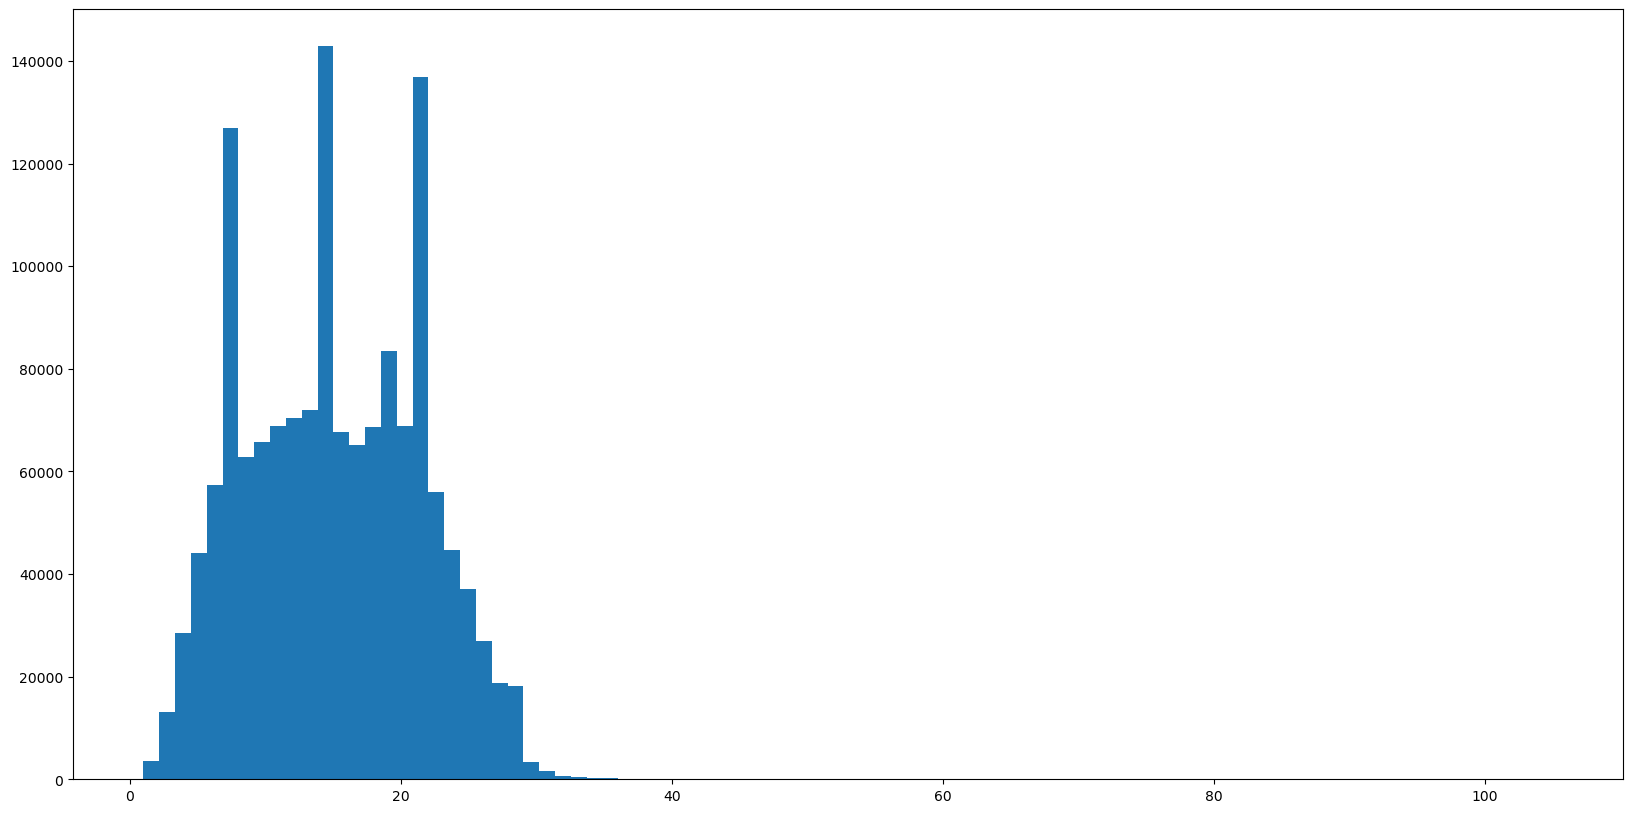

In [17]:
#First we need to see how much we need to pad it to get the most of it.
import matplotlib.pyplot as plt

lengths = [len(t.split(' ')) for t in tweets_train]
fig = plt.figure(figsize=(20, 10))
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

### The histogram shows us the lenght of the sequence of texts and as such we can pad it to have the most included.

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(tweets_train_pre)
tweets_train_pad = pad_sequences(sequences, truncating='post', maxlen=30, padding='post')
tweets_train_pad[50]

array([ 2018,     3, 26302,   251,    37,    23,     7,     9,   422,
         221,    27,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

### Labels were set and functions were created that could easily convert the emotions to a value to be used in the training of the model and convert those values back to string.


In [19]:
classes = set(emolabel_train)
print(classes)

{'sadness', 'trust', 'anticipation', 'joy', 'disgust', 'fear', 'anger', 'surprise'}


In [20]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [21]:
classes_to_index

{'sadness': 0,
 'trust': 1,
 'anticipation': 2,
 'joy': 3,
 'disgust': 4,
 'fear': 5,
 'anger': 6,
 'surprise': 7}

In [22]:
index_to_classes

{0: 'sadness',
 1: 'trust',
 2: 'anticipation',
 3: 'joy',
 4: 'disgust',
 5: 'fear',
 6: 'anger',
 7: 'surprise'}

In [23]:
#Function used to convert string values to numeric values to be used in training along with the padded data.
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
ids_to_names = lambda labels: np.array([index_to_classes.get(x) for x in labels])

In [24]:
train_emolabels = names_to_ids(emolabel_train)
print (tweets_train_pre[0])
print (emolabel_train[0])
print(train_emolabels[0])

people who post add me on snapchat must be dehydrate cuz man that
anticipation
2


# MODEL CREATION
#### Genuinely just relied on Google for the formatting and trial and error.
Model was created based on RNN and utilized the Keras Layers to aid with long-form content by using LSTM to mitigate the initial proplems with RNN which is it's potentially to lean towards improper weight gradients when it comes to large data looping too much and messing with the weight values.
With all that being said, even without pre-processing it still performed relatively well. The Origianal Training of the Model was done at batches of 64, to save time and Epochs of 25. The 64, which is larger than the usual 32, may have been faster but could have impacted accuracy as well. As such, in the second round with the preprocessed data, it was changed to 32 and 15. (I got tired)

In [25]:
import tensorflow as tf

model4 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(50000, 16, input_length=30),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(8, activation='softmax')
])

model4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 16)            800000    
                                                                 
 bidirectional (Bidirectiona  (None, 30, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 8)                 328       
                                                                 
Total params: 816,008
Trainable params: 816,008
Non-trainable params: 0
_________________________________________________________________


# Model Training
No validation data sure made things interesting.
Original Training = 18/25 Epoch for Batches of 64.
Current = 10 Epoch for Batches of 32.
There was an issue whereby the predit function did not produce the desired results and I thought the model was wrong. However, it turned out I was using an outdated TensorFlow model function and I have learned the importance of reading a Module information and formatting. The working model produce a single value which is then converted from index_to_ids from the previously created function. The most optimal set of intructions and parameter are what we have now in this document. 

In [26]:
# training!
epochs = 10
batch_size = 32

history4 = model4.fit(tweets_train_pad, train_emolabels, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)]
                    #validation_data = (X_test, y_test))
                   )
print('training finish')

Epoch 1/10
45487/45487 [==============================] - 706s 15ms/step - loss: 1.2908 - accuracy: 0.5352
Epoch 2/10
45487/45487 [==============================] - 613s 13ms/step - loss: 1.1868 - accuracy: 0.5733
Epoch 3/10
45487/45487 [==============================] - 680s 15ms/step - loss: 1.1449 - accuracy: 0.5892
Epoch 4/10
45487/45487 [==============================] - 644s 14ms/step - loss: 1.1174 - accuracy: 0.6000
Epoch 5/10
45487/45487 [==============================] - 731s 16ms/step - loss: 1.0970 - accuracy: 0.6077
Epoch 6/10
45487/45487 [==============================] - 644s 14ms/step - loss: 1.0811 - accuracy: 0.6141
Epoch 7/10
45487/45487 [==============================] - 641s 14ms/step - loss: 1.0677 - accuracy: 0.6196
Epoch 8/10
45487/45487 [==============================] - 620s 14ms/step - loss: 1.0562 - accuracy: 0.6237
Epoch 9/10
45487/45487 [==============================] - 628s 14ms/step - loss: 1.0458 - accuracy: 0.6281
Epoch 10/10
45487/45487 [============

In [27]:
#Padding for Test Data
sequences_test = tokenizer.texts_to_sequences(tweets_test_pre)
tweets_test_pad = pad_sequences(sequences_test, truncating='post', maxlen=30, padding='post')
tweets_test_pad[50]

array([  44,   16,  845,    3,  310,   94, 1901,  824,  165,    5,   12,
       1121,  628,   15,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [28]:
#Predicting
pred = np.argmax(model4.predict(tweets_test_pad), axis=-1)


12875/12875 [==============================] - 66s 5ms/step


In [29]:
pred[50]

3

In [30]:
pred.shape, tweets_test_pad.shape

((411972,), (411972, 30))

### Converting Prediction index to name and comparing test results.

In [31]:
pred_result = ids_to_names(pred)
pred_result[:5]

array(['anticipation', 'anticipation', 'joy', 'joy', 'trust'],
      dtype='<U12')

In [32]:
print(tweets_test[50])
print(pred_result[50])

When your husband forgots  to turn his alarm clock off and its a bank holiday. That. <LH>
joy


In [33]:
my_submission = pd.DataFrame({'id': twitTest_df.tweet_id, 'emotion': pred_result})
my_submission.to_csv('submissionNSWED10Epo50Kl30.csv', index=False)